In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pinocchio as pin
from embedding import Embedding
from forward_kinematics import ForwardKinematic
from dynamical_system import DynamicalSystem

In [2]:
fk = ForwardKinematic(urdf_file='franka_description/urdf/panda_no_gripper.urdf')
config_dim = fk.model.nq

K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)

config_attractor = pin.randomConfiguration(fk.model)
print(f'attractor : {config_attractor}')

x = np.array([[-3], [0], [0.]])[np.newaxis, :]

e = Embedding(dimension=config_dim, x=x.repeat(1, 0), fk=fk)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.01)

attractor : [-0.13413041  0.47233771 -0.80239598 -1.4838798   2.68362164  3.49465624
  0.80534054]


In [3]:
config_start = pin.neutral(fk.model)
initial_speed = np.zeros_like(config_start)
q = config_start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,500):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')
ps= np.stack(positions)

average execution frequency : 228.2479 Hz


# Visualization

In [4]:
from itertools import combinations

def plot_coupled_embeddings(coordinates, attractor, streamlines, embedding, start):
    couples = list(combinations(np.linspace(0, coordinates.shape[1]-1, coordinates.shape[1]), r=2))
    fig, axs = plt.subplots(coordinates.shape[1], int(len(couples)/coordinates.shape[1]))
    fig.set_size_inches(15, 20)
    row = -1
    for b, couple in enumerate(couples):
        if axs.ndim == 1:
            ax = axs[b]
        else:
            if b%axs.shape[1] == 0: row +=1
            ax = axs[row, b%axs.shape[1]]
        angle1 = min(int(couple[0]), int(couple[1]))
        angle2 = max(int(couple[0]), int(couple[1]))
        x = np.unique(embedding[:, angle1])
        y = np.unique(embedding[:, angle2])
        f = embedding[:, -1].reshape(tuple(x.shape[0] for _ in range(embedding.shape[1]-1)))
        dims_to_sum = tuple(map(lambda tup: tup[0], filter(lambda tup: tup[1], [(i, i not in (angle1, angle2)) for i in range(coordinates.shape[1])])))
        z = f.sum(dims_to_sum) 
        if angle1 == 0:
            ax.contourf(x, y, z, antialiased=False, alpha=0.35, cmap=cm.coolwarm)
        else:
            ax.contourf(x, y, z.T, antialiased=False, alpha=0.35, cmap=cm.coolwarm)
        if attractor is not None:
            ax.scatter(attractor[angle1], attractor[angle2], marker='*', label='target', c='navy', s=40)
        if start is not None:
            ax.scatter(start[angle1], start[angle2], marker='*', label='start', c='gold', s=40)
        if streamlines is not None:
            ax.scatter(streamlines[:, angle1], streamlines[:, angle2], label='path', c='black', s=1)
        ax.set_xlabel(f'q{angle1+1}')
        ax.set_ylabel(f'q{angle2+1}')
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([y.min(), y.max()])
        ax.legend(loc='upper right')
    fig.tight_layout()
    return ax


In [5]:
def generate_grid_coordinates(joint_limits, resolution: int=5):
    qs = tuple(np.linspace(limit['lower'], limit['upper'], resolution) for limit in joint_limits)
    grids = np.meshgrid(*qs)
    return np.column_stack(tuple(g.ravel() for g in grids))

In [6]:
from utils.franka_parameters import joint_limits

grid = generate_grid_coordinates(joint_limits=joint_limits, resolution=5)
print(grid.shape)

(78125, 7)


In [7]:
a = np.zeros((grid.shape[0], grid.shape[1]+1))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q).sum()
    a[i] = np.array([*q, p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 12122.737727273283


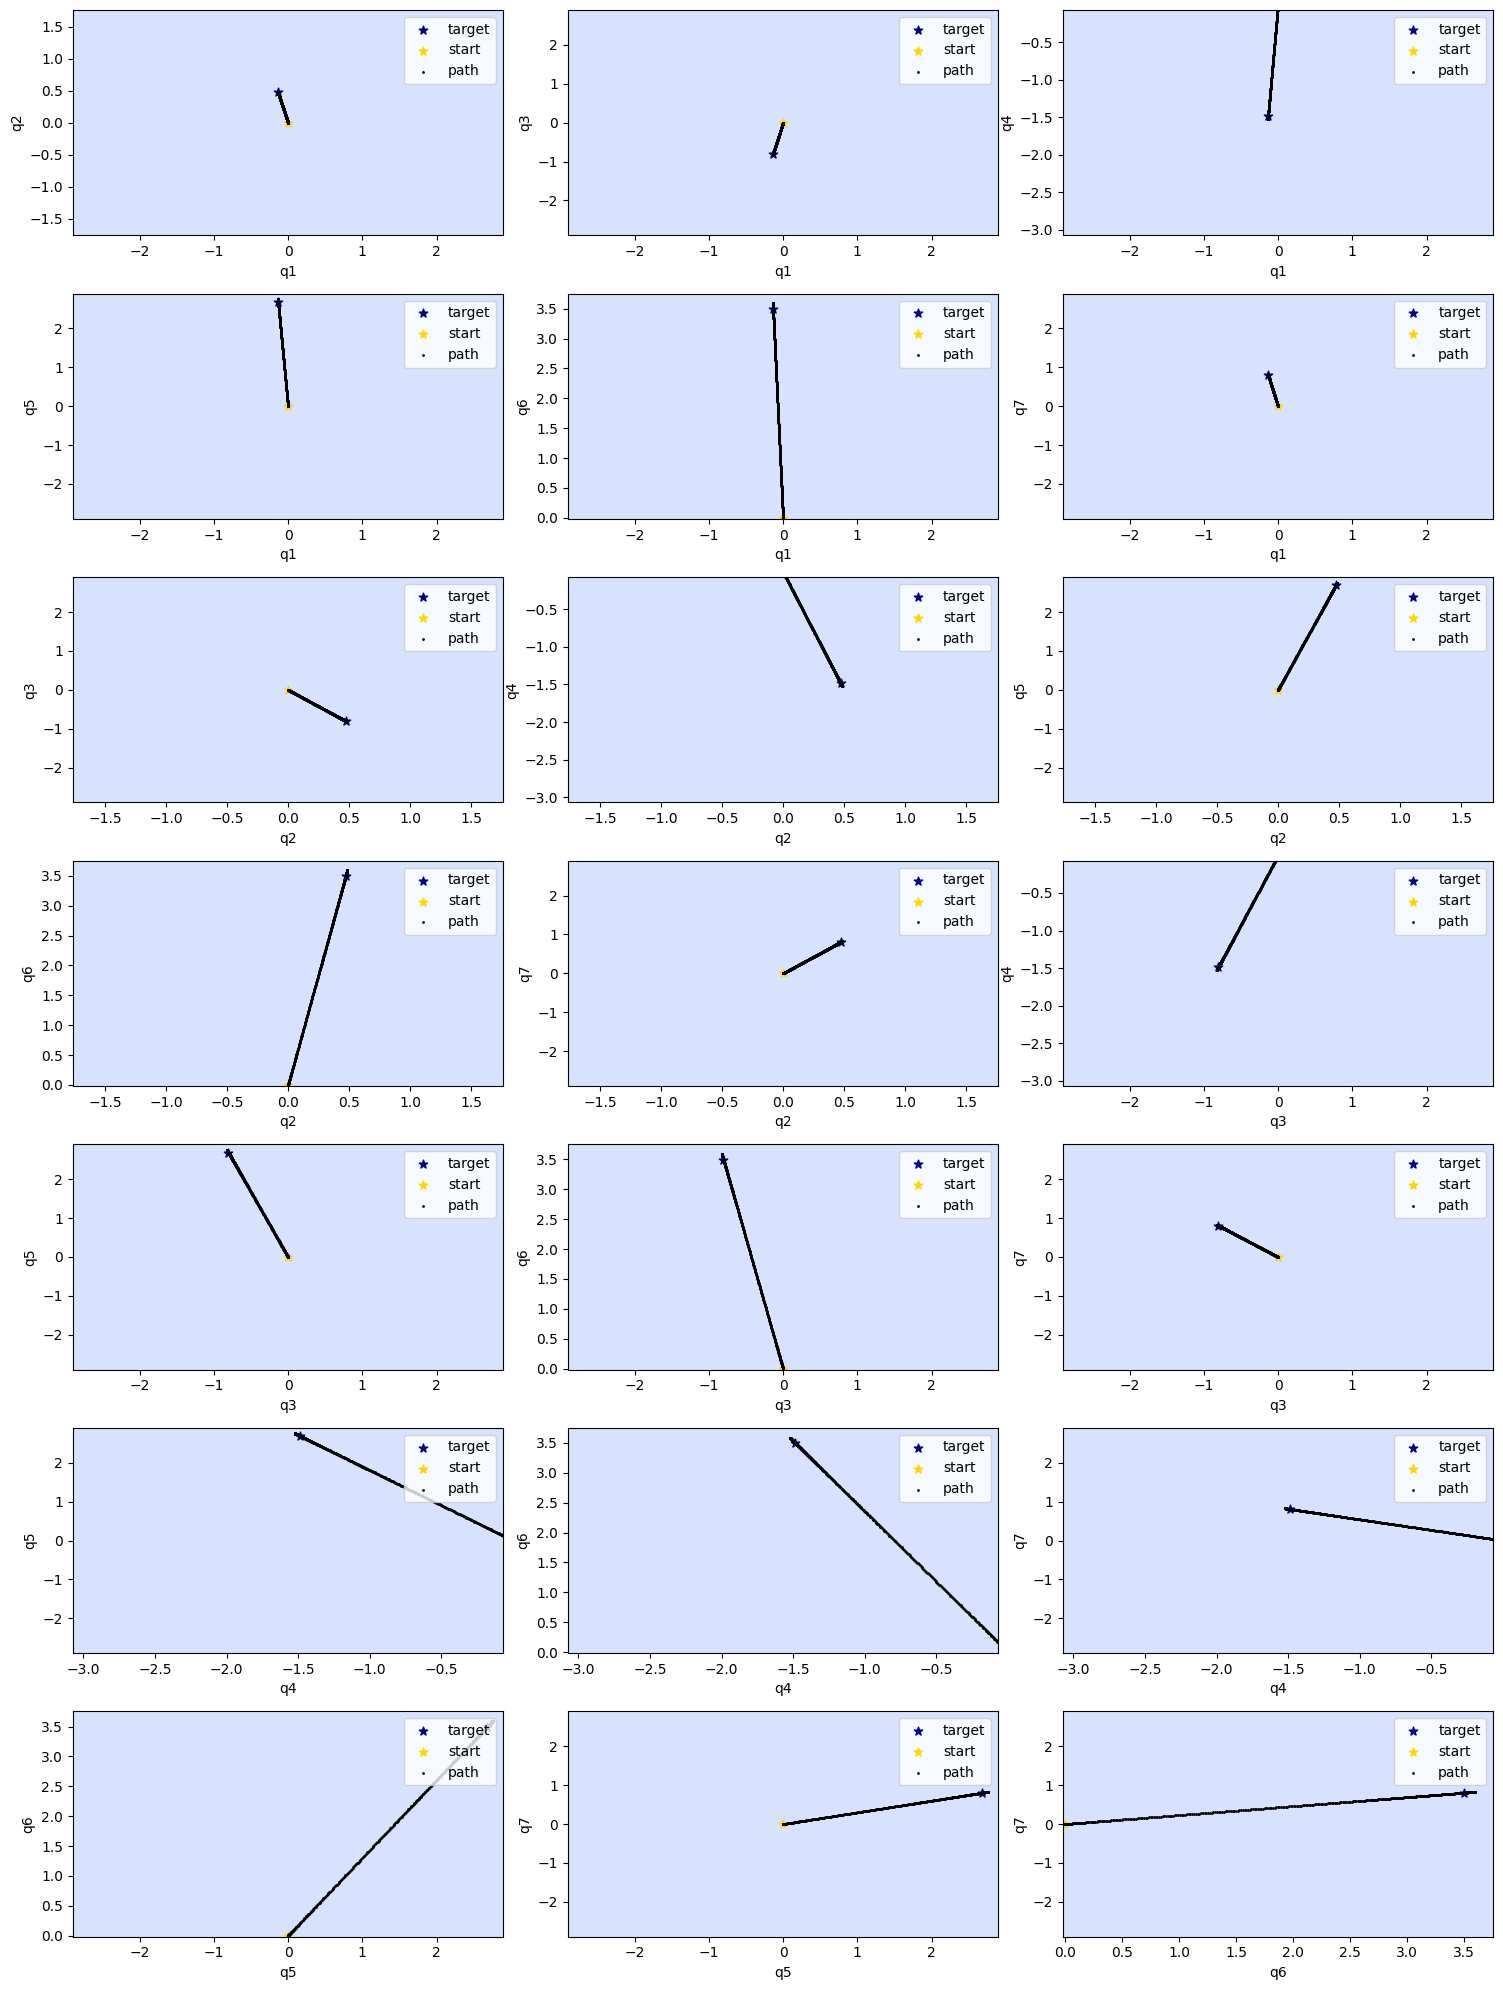

In [8]:
plot_coupled_embeddings(grid, config_attractor, embedding=a, streamlines=ps, start=config_start)
plt.show()